# Estimating the posterior mean and standard devation using neural networks

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.model_selection import train_test_split

import numpy as np
import os
import time
import h5py
from urllib.request import urlretrieve as urlretrieve

import matplotlib.pyplot as plt



## (Down)load data

nm= 125
nd= 12
(3350000, 125)
(3350000, 12)
(1650000, 125)
(1650000, 12)


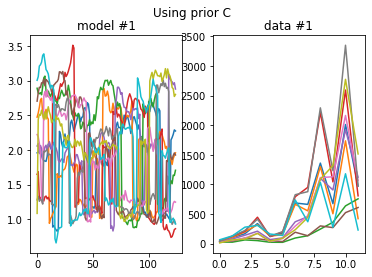

In [2]:
usePrior = 'C'
if (usePrior=='A'):
    #file_training = '1D_P14_NO500_451_ABC200001_1000.h5'
    #file_sampling = '1D_P14_NO500_451_ABC200001_1000_ME1_aT1_CN1.h5'
    file_training = '1D_P14_NO500_451_ABC5000000_0000.h5'
    file_sampling = '1D_P14_NO500_451_ABC5000000_0000_ME0_aT1_CN1.h5'
elif (usePrior=='B'):
    #file_training = '1D_P51_NO500_451_ABC200001_1000.h5'
    #file_sampling = '1D_P51_NO500_451_ABC200001_1000_ME1_aT1_CN1.h5'
    file_training = '1D_P51_NO500_451_ABC5000000_0000.h5'
    file_sampling = '1D_P51_NO500_451_ABC5000000_0000_ME0_aT1_CN1.h5'
elif (usePrior=='C'):
    #file_training = '1D_P22_NO500_451_ABC200001_1000.h5'
    #file_sampling = '1D_P22_NO500_451_ABC200001_1000_ME1_aT1_CN1.h5'
    file_training = '1D_P22_NO500_451_ABC5000000_0000.h5'
    file_sampling = '1D_P22_NO500_451_ABC5000000_0000_ME0_aT1_CN1.h5'

# Download if h5 files does not exist    
if not os.path.exists(file_training):
  print("Downloading %s" % (file_training))
  urlretrieve("https://github.com/cultpenguin/probabilistic-inverse-problems_and_ml/raw/main/%s" % (file_training),file_training)
if not os.path.exists(file_sampling):
  print("Downloading %s" % (file_sampling))
  urlretrieve("https://github.com/cultpenguin/probabilistic-inverse-problems_and_ml/raw/main/%s" % (file_sampling),file_sampling)    
    
    
f_training = h5py.File(file_training, 'r')
f_sampling = h5py.File(file_sampling, 'r')

#print(list(f_sampling.keys()))
#print(list(f_training.keys()))

#M = f_training['M1'][:]
#D = f_training['D2'][:]

N_use = 10000001
N = f_training['M1'].shape[0]
N_use = np.min([N,N_use])
M = f_training['M1'][0:N_use,:]
D = f_training['D2'][0:N_use,:]

nd=D.shape[1]
nm=M.shape[1]
print('nm= %d' % nm)
print('nd= %d' % nd)
plt.subplot(1,2,1)
plt.plot(M[0:10,:].T)
plt.title('model #1')
plt.subplot(1,2,2)
plt.title('data #1')
plt.plot(D[0:10,:].T)
plt.suptitle('Using prior %s' % (usePrior))

# split data into training and validation data
m_train, m_test, d_train, d_test = train_test_split(M,D, test_size=0.33, random_state=42)
print(m_train.shape)
print(d_train.shape)
print(m_test.shape)
print(d_test.shape)



## Setup neural network

In [3]:
# Define negative log-likelihood (used as loss function) for the Normal distribution
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

# Setuyp the network 
print('Full model estimate mean+std')
nhidden=5
nunits=40
nunits=80
#nunits=120
pdropout=0;

d_floor = 1e-3 
d_scale=1
learning_rate = 1e-3
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(nunits, input_dim=nd, kernel_initializer='normal', activation='relu'))
for i in range(nhidden):
    model.add(tf.keras.layers.Dense(nunits, activation='relu'))
    if (pdropout>0):
        model.add(tf.keras.layers.Dropout(pdropout))
model.add(tf.keras.layers.Dense(nm+nm))
model.add(tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(loc=t[..., :nm],scale=d_floor + tf.math.softplus(d_scale * t[..., nm:])))),

#optim = tf.keras.optimizers.Adamax()
optim = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optim, loss=negloglik);

# Print model info
model.summary()


Full model estimate mean+std
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 80)                1040      
_________________________________________________________________
dense_1 (Dense)              (None, 80)                6480      
_________________________________________________________________
dense_2 (Dense)              (None, 80)                6480      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                6480      
_________________________________________________________________
dense_4 (Dense)              (None, 80)                6480      
_________________________________________________________________
dense_5 (Dense)              (None, 80)                6480      
_________________________________________________________________
dense_6 (Dense)            

2021-10-16 00:32:26.042250: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-10-16 00:32:26.055545: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2021-10-16 00:32:26.055568: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-10-16 00:32:26.056543: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (o

## Train the network

In [4]:
#try:
#    %load_ext tensorboard
#    %tensorboard --logdir logs
#except:
#    print("No iPython")


In [ ]:
batch_size=64
n_epochs=10000
patience = 100

# N_use = 1000000
patience = 100;batch_size = 256;n_epochs = 2000 
# N_use = 5000000
patience = 100;batch_size = 1024;n_epochs = 2000 



fout='Prior%s_N%d_meanstd_bs%d_ep%d_nh%d_nu%d_do%d' % (usePrior,N_use,batch_size,n_epochs,nhidden,nunits,pdropout*100)

model_h5 = fout + '.h5'

if (os.path.isfile(model_h5)):
    # Neural net has allready been trained
    print('Neural network has allready been trained - loading weights from %s' % (model_h5))
    model.load_weights(model_h5)

else:
    # Neural net has not been trained
    print('Training neural network')
    
    # Tensorboard
    logdir = os.path.join("logs" , fout )
    print("Logs in %s" % (logdir) )
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, profile_batch=0)
    
    # Early stopping
    earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=3)
    
    t0=time.time()

    out = model.fit(d_train, m_train, 
            epochs=n_epochs, 
            batch_size=batch_size,
            verbose=1,
            validation_data=(d_test,m_test),
            callbacks=[tensorboard_callback,earlystopping_callback])

    t1=time.time()
    t_train=t1-t0
    print("Elapsed time for training = %3.1fs" % (t_train))

    # Save h5 model
    print('%s: Save model weights' % (fout))
    #tf.keras.models.save_model(model, model_h5, save_format='h5')    
    model.save_weights(model_h5)

    # Plot loss
    plt.figure(1)
    plt.semilogy(out.history['loss'], label='Train')
    plt.semilogy(out.history['val_loss'], label='Validation')
    plt.xlabel('Iteration #')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()

    

Training neural network
Logs in logs/PriorC_N5000000_meanstd_bs1024_ep2000_nh5_nu80_do0


2021-10-16 00:32:27.778289: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2000
3272/3272 [==============================] - 58s 17ms/step - loss: 6014.1992 - val_loss: 0.8582
Epoch 2/2000
3272/3272 [==============================] - 56s 17ms/step - loss: 0.8431 - val_loss: 0.8208
Epoch 3/2000
3272/3272 [==============================] - 56s 17ms/step - loss: 0.8177 - val_loss: 0.8021
Epoch 4/2000
3272/3272 [==============================] - 56s 17ms/step - loss: 0.8031 - val_loss: 0.7924
Epoch 5/2000
3272/3272 [==============================] - 55s 17ms/step - loss: 0.7904 - val_loss: 0.7873
Epoch 6/2000
3272/3272 [==============================] - 55s 17ms/step - loss: 0.7824 - val_loss: 0.7742
Epoch 7/2000
3272/3272 [==============================] - 55s 17ms/step - loss: 0.7722 - val_loss: 0.7654
Epoch 8/2000
3272/3272 [==============================] - 55s 17ms/step - loss: 0.7653 - val_loss: 0.7657
Epoch 9/2000
3272/3272 [==============================] - 55s 17ms/step - loss: 0.7589 - val_loss: 0.7567
Epoch 10/2000
3272/3272 [==================

## Predict posterior mean and standard deviation

In [ ]:
# load observed data
D_obs= f_sampling['D_obs'][:]
n_est = D_obs.shape[0]

t0=time.time()
POST = model(D_obs)
M_mean = POST.mean().numpy().T
M_std = POST.stddev().numpy().T
t1=time.time()
t_pred = t1-t0;
print('prediction time: %5.1fms / %d models' % (1000*t_pred, n_est))
print('prediction time: %4.0f modsels/s' % (1/(t_pred/n_est)))


## Plot some figures

In [ ]:
# load mean and sdt obtained using sampling
M_mean_sampling = f_sampling['M_est'][:].T
M_std_sampling = f_sampling['M_std'][:].T

# MEAN
plt.figure(figsize=(32,12))
plt.subplot(211)
A = M_std/1.4;
indices = A > 1
A[indices] = 1
A=1-A
print(np.max(A))
plt.imshow(M_mean, vmin=1, vmax=2.5, cmap='jet', alpha=A)
plt.imshow(M_mean, vmin=1, vmax=2.5, cmap='jet')
plt.title('M mean ML  t = %4.2f ms' % (1000*t_pred))

plt.subplot(212)
A = M_std_sampling/1.4;
indices = A > 1
A[indices] = 1
A=1-A
plt.imshow(M_mean_sampling, vmin=1, vmax=2.5, cmap='jet', alpha=A)
plt.imshow(M_mean_sampling, vmin=1, vmax=2.5, cmap='jet')
plt.title('M mean sampling')
#plt.colorbar()
plt.savefig(fout + '_mean_std')    

# STD
plt.figure(figsize=(32,12))
plt.subplot(211)
plt.imshow(M_std, vmin=0, vmax=1, cmap='gray_r')
plt.title('M std ML  t = %4.2f ms' % (1000*t_pred))
plt.subplot(212)
plt.imshow(M_std_sampling, vmin=0, vmax=1, cmap='gray_r')
plt.title('M std sampling')
#plt.colorbar()
plt.savefig(fout + '_std')    



